# Search

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/searching.ipynb)

## Linear Search

Suppose you have a list.

In [2]:
t = [5, 1, 2, 4, 2]

And you want to know whether an element appears in the list. You can use the `in` operator, which returns `True` or `False`.

In [3]:
5 in t, 6 in t

(True, False)

If you want to know where in the list it is, you can use `index`, which returns the index of the element if it appears.

In [4]:
t.index(2)

2

Or raises a `ValueError` otherwise.

In [5]:
try:
    t.index(6)
except ValueError as e:
    print(e)

6 is not in list


The following function does the same thing as `string.index`:

In [6]:
def index(t, target):
    for i, x in enumerate(t):
        if x == target:
            return i
    raise ValueError(f'{target} is not in list')

In [7]:
index(t, 2)

2

In [8]:
try:
    index(t, 6)
except ValueError as e:
    print(e)

6 is not in list


The runtime of this kind of search is in `O(n)`, where `n` is the length of the list, because

1. If the target is not in the list, you have to check every element in the list.

2. If the target is in a random location, you have to check half the list on average.

As an exception, if you know that the target is within the first `k` elements, for a value of `k` that does not depend on `n`, you can consider this search `O(1)`.

## Bisection

If we know that the elements of the list are in order, we can do better.

The `bisect` module provides an implementation of a "bisection search", which works by

1. Checking the element in the middle of the list. If it's the target, we're done.

2. If the middle element is larger than the target, we search the left half.

3. If the middle element is smaller than the target, we search the right half.

[Here is the documentation of the bisect modle](https://docs.python.org/3/library/bisect.html).

To test it, we'll start with a sorted list.

In [9]:
t.sort()
t

[1, 2, 2, 4, 5]

`bisect_left` is similar to `index`

In [15]:
from bisect import bisect_left

bisect_left(t, 1), bisect_left(t, 2), bisect_left(t, 4), bisect_left(t, 5)

(0, 1, 3, 4)

But with elements that are not in the list, it returns their insertion point, that is, the place where you would put the target to keep the list sorted.

In [11]:
bisect_left(t, 6)

5

We can use `bisect_left` to implement `index`, like this:

In [12]:
from bisect import bisect_left

def index_bisect(a, x):
    """Locate the leftmost value exactly equal to x"""
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError(f'{x} not in list')

In [13]:
index_bisect(t, 1), index_bisect(t, 2), index_bisect(t, 4), index_bisect(t, 5)

(0, 1, 3, 4)

In [14]:
try:
    index_bisect(t, 6)
except ValueError as e:
    print(e)

6 not in list


**Exercise:** Write your own version of `bisect_left`. You can do it iteratively or recursively.

In [1]:
def bisect_left_recursive(arr, target, lo=0, hi=None):
    if hi is None:
        hi = len(arr)
    if lo >= hi:
        return lo

    mid = (lo + hi) // 2
    if arr[mid] < target:
        return bisect_left_recursive(arr, target, mid + 1, hi)
    else:
        return bisect_left_recursive(arr, target, lo, mid)



Target not found


In [ ]:
def bisect_left_iterative(arr, target):
    lo, hi = 0, len(arr)
    while lo < hi:
        mid = (lo + hi) // 2
        if arr[mid] < target:
            lo = mid + 1
        else:
            hi = mid
    return lo


Each time through the loop, we cut the search region in half, so if we start with `n` elements, we have `n/2` during the next loop, `n/4` during the second loop, and so on. When we get to 1 element, we're done.

[See this animation](https://blog.penjee.com/binary-vs-linear-search-animated-gifs/)

So how many steps does that take? Thinking about it in reverse, starting with 1, how many times do we have to double it before we get to `n`? In math notation, the question is

$$2^x = n$$

Where `x` is the unknown number of steps. Taking the log of both sides, base 2:

$$x = log_2 n$$

In terms of order of growth, bisection search is in `O(log n)`. Notice that we don't bother to specify the base of the logarithm, because a log in one base is a constant multiple of a log in any other base.

`bisect` also provides methods to insert elements while maintaining sorted order.

In [ ]:
from bisect import insort

insort(t, 3)
t

However, as the documentation explains, "Keep in mind that the O(log n) search is dominated by the slow O(n) insertion step."

## Binary search tree

Using a sorted array to support log-time search is a reasonable choice if we don't have to add or remove elements very often.

But if the number of add/remove operations is similar to the number of searches, the overall performance would be linear.

We can solve that problem with a [binary search tree](https://en.wikipedia.org/wiki/Binary_search_tree).

To implement a tree, I'll define a new class that represents a `Node`.
Each node contains data and a reference to two "children" called `left` and `right`.
(It's called a binary tree because every node has two children).

In [16]:
class Node:
    def __init__(self, data, left=None, right=None):
        self.data = data
        self.left = left
        self.right = right

    def __repr__(self):
        return f'Node({self.data}, {repr(self.left)}, {repr(self.right)})'

Here's how we can instantiate two nodes.

In [17]:
node3 = Node(3)
node10 = Node(10)

Because `Node` provides `__repr__`, we can display a node like this.

In [18]:
node3

Node(3, None, None)

Now we'll make a parent node that has the first two nodes as children.

In [19]:
node8 = Node(8, node3, node10)
node8

Node(8, Node(3, None, None), Node(10, None, None))

I'll define another class to represent the tree.
The only thing it contains is a reference to the top of the tree, which is confusingly called the root node.

In [20]:
class BSTree:
    def __init__(self, root=None):
        self.root = root

    def __repr__(self):
        return f'BSTree({repr(self.root)})'

Here's tree with a reference to `node8`, so it implicitly contains `node3` and `node10` as well.

In [21]:
tree = BSTree(node8)
tree

BSTree(Node(8, Node(3, None, None), Node(10, None, None)))

A binary tree is a binary search tree if for every node (1) the value of the left child is lower and (2) the value of the right child is higher.
Let's assume for now that there are no duplicates.

We can check whether a tree is a BST like this:

In [23]:
def is_bst(tree):
    return is_bst_rec(tree.root)

def is_bst_rec(node):
    if node is None:
        return True

    if node.left and node.left.data > node.data:
        return False
    if node.right and node.right.data < node.data:
        return False

    return is_bst_rec(node.left) and is_bst_rec(node.right)

In [24]:
is_bst(tree)

True

And let's see an example where it's not true.

In [25]:
node5 = Node(5, node10, node3)
node5

Node(5, Node(10, None, None), Node(3, None, None))

In [26]:
tree2 = BSTree(node5)
is_bst(tree2)

False

## Draw the Tree

One of the better functions for drawing trees is part of a package called `EoN`, for "Epidemics on Networks", which provides "tools to study the spread of SIS and SIR diseases in networks".

The function we'll use is called [hierarchy_pos](https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.hierarchy_pos.html#EoN.hierarchy_pos).
It takes as a parameter a NetworkX graph that represents a tree, and it returns a dictionary that maps from each node to a position in the Cartesian plane.
If we pass this dictionary to `nx.draw`, it lays the tree out accordingly.

In [27]:
try:
    import EoN
except ImportError:
    !pip install EoN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.2-py3-none-any.whl size=122468 sha256=62890ee965587ff6810964279cb9f19d5079703caf9a5972e318050de3342a36
  Stored in directory: /root/.cache/pip/wheels/10/ec/88/6daefcc5ebdf7e373db9da6a61386f33143571d885c4c7708a
Successfully built EoN


In [28]:
import networkx as nx

def add_edges(node, G):
    """Make a NetworkX graph that represents the heap."""
    if node is None:
        return

    G.add_node(node, label=node.data)
    for child in (node.left, node.right):
        if child:
            G.add_edge(node, child)
            add_edges(child, G)

In [29]:
G = nx.DiGraph()
add_edges(tree.root, G)
G.nodes()

NodeView((Node(8, Node(3, None, None), Node(10, None, None)), Node(3, None, None), Node(10, None, None)))

In [30]:
labels = {node: node.data for node in G.nodes()}
labels

{Node(8, Node(3, None, None), Node(10, None, None)): 8,
 Node(3, None, None): 3,
 Node(10, None, None): 10}

In [31]:
from EoN import hierarchy_pos

def draw_tree(tree):
    G = nx.DiGraph()
    add_edges(tree.root, G)
    pos = hierarchy_pos(G)
    labels = {node: node.data for node in G.nodes()}
    nx.draw(G, pos, labels=labels, alpha=0.4)

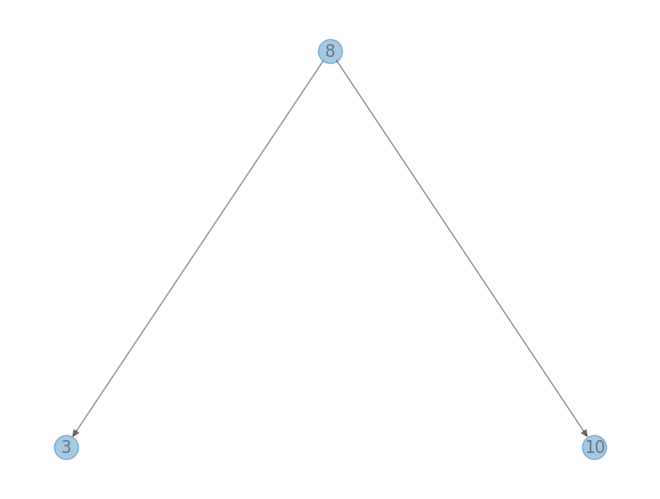

In [32]:
draw_tree(tree)

## Search

Given a tree and a target value, how do we determine whether the target is in the tree?

1. Start at the root. If you find the target, stop.

2. If the target is less than the value at the root, go left.

3. If the target is greater than the value at the root, go right.

4. If you get to a non-existent node, stop.

**Exercise:** Write a function called `search` that takes a `BSTree` and a target value and returns `True` if the target value appears in the tree.

In [33]:
#Cool method i made up by adapting list search
class Node:
    def __init__(self, data, left = None, right = None):
        self.data = data
        self.left = left
        self.right = right
    def __repr__(self):
        return f"Node({self.data},{repr(self.left)}, {repr(self.right)})"
    def __iter__(self):
        yield self.data
        if isinstance(self.left, Node):
            yield from self.left
        if isinstance(self.left, Node):
            yield from self.right

    def search(self,target):
        search_list = []
        for nodes in self:
            search_list.append(nodes)
        if target in search_list:
            return True
        return False
class BSTree:
    def __init__(self, root = None):
        self.root = root
    def __repr__(self):
        return f'BSTree({repr(self.root)})'
node1 =Node(1)
node2 = Node(2)
node3 = Node(3, node1,node2)


In [35]:
#Exercise Solution
class Node:
    def __init__(self, data, left = None, right = None):
        self.data = data
        self.left = left
        self.right = right
    def __repr__(self):
        return f"Node({self.data},{repr(self.left)}, {repr(self.right)})"

    def search(self,target):
        if self.data == target:
            return True
        elif self.data > target:
            if self.left:
                return (self.left).search(target)
        elif self.data<target:
            if self.right:
                return (self.right).search(target)
        return False
class BSTree:
    def __init__(self, root = None):
        self.root = root
    def __repr__(self):
        return f'BSTree({repr(self.root)})'
node1 =Node(1)
node2 = Node(4)
node3 = Node(3, node1,node2)
node3.search(4)

True

**Exercise:** Many tree operations lend themselves to recursive implementations. Write a function called `search_rec` that searches the tree recursively.

Hint: Start with a copy of `is_bst`.

In [ ]:
class Node:
    def __init__(self, data, left = None, right = None):
        self.data = data
        self.left = left
        self.right = right
    def __repr__(self):
        return f"Node({self.data},{repr(self.left)}, {repr(self.right)})"

    def search(self,target):
        if self.data == target:
            return True
        elif self.data > target:
            if self.left:
                return (self.left).search(target)
        elif self.data<target:
            if self.right:
                return (self.right).search(target)
        return False
class BSTree:
    def __init__(self, root = None):
        self.root = root
    def __repr__(self):
        return f'BSTree({repr(self.root)})'
node1 =Node(1)
node2 = Node(4)
node3 = Node(3, node1,node2)
node3.search(4)

## Insert

The point of the BST is that we can add and remove elements efficiently, compared to a sorted array.

So let's see what that looks like.

In [68]:
def insert(tree, data):
    tree.root = insert_node(tree.root, data)

def insert_node(node, data):
    if node is None:
        return Node(data)

    if data < node.data:
        node.left = insert_node(node.left, data)
    else:
        node.right = insert_node(node.right, data)

    return node

We'll test it by starting with an empty tree and adding elements one at a time.

In [69]:
tree = BSTree()

values = [8, 3, 10, 1, 6, 14, 4, 7, 13]
for value in values:
    insert(tree, value)

tree

BSTree(Node(8,Node(3,Node(1,None, None), Node(6,Node(4,None, None), Node(7,None, None))), Node(10,None, Node(14,Node(13,None, None), None))))

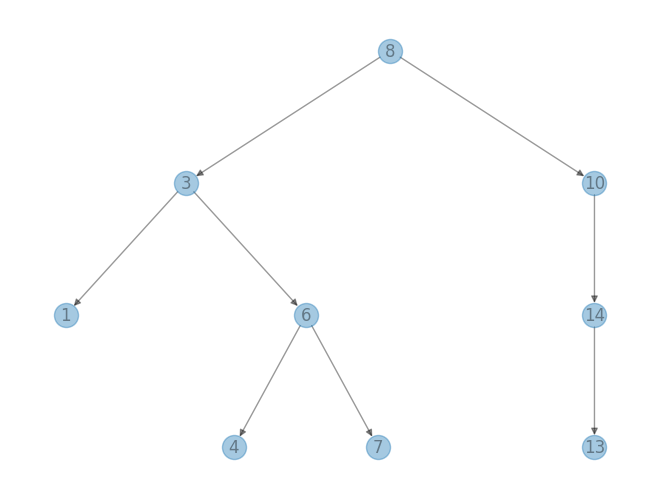

In [38]:
draw_tree(tree)

If things have gone according to plan, the result should be a BST.

In [39]:
is_bst(tree)

True

## Sorting

If we traverse the tree recursively and print the elements as we go, we get the values in sorted order.

In [40]:
def print_tree(tree):
    print_tree_rec(tree.root)

def print_tree_rec(node):
    if node is None:
        return

    print_tree_rec(node.left)
    print(node.data, end=' ')
    print_tree_rec(node.right)

In [41]:
print_tree(tree)

1 3 4 6 7 8 10 13 14 

**Exercise:** Write a generator method called `iterate_tree` that traverses the tree and yields the elements in order.

You can do this iteratively or recursively.

In [101]:
def iterate_tree(tree):
   yield from iterate_tree_rec(tree.root)


def iterate_tree_rec(node):
    if node is not None:
        yield from iterate_tree_rec(node.left)
        yield node.data
        yield from iterate_tree_rec(node.right)


for v in iterate_tree(tree):
    print(v)

1
3
4


In [96]:
next(gen)

StopIteration: 

In [66]:
tree = BSTree()

values = [8, 3, 10, 1, 6, 14, 4, 7, 13]
for value in values:
    insert(tree, value)

tree

BSTree(Node(8,Node(3,Node(1,None, None), Node(6,Node(4,None, None), Node(7,None, None))), Node(10,None, Node(14,Node(13,None, None), None))))

In [49]:
list(tree)

TypeError: 'BSTree' object is not iterable

## Badness 10000

If the tree is reasonably well balanced, the height is proportional to `log n`, where `n` is the number of elements.

But let's see what happens if we add elements in sorted order.

In [104]:
tree3 = BSTree()
for x in sorted(values):
    insert(tree3, x)

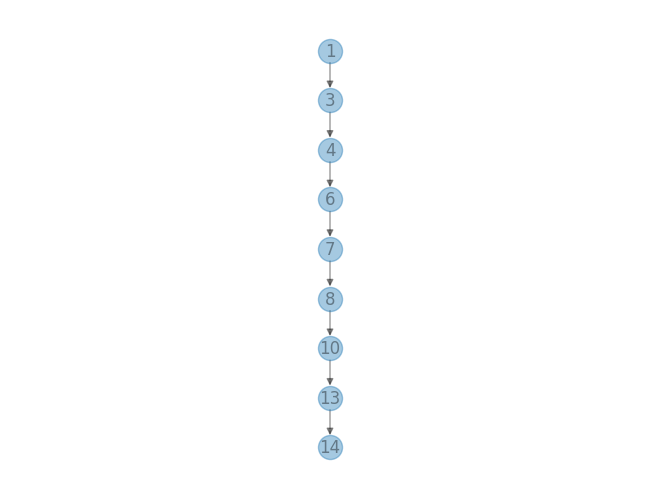

In [105]:
draw_tree(tree3)

Now traversing the tree takes linear time.
To avoid this problem, there are variations of BST that are [self-balancing](https://en.wikipedia.org/wiki/Self-balancing_binary_search_tree).

Most are based on [tree rotation](https://en.wikipedia.org/wiki/Tree_rotation) operations.
For example, the following is a function that rotates a tree to the left (following Wikipedia's nomenclature for what "left" and "right" mean).

In [106]:
def rotate_left(node):
    if node is None or node.right is None:
        return node

    pivot = node.right
    node.right = pivot.left
    pivot.left = node

    return pivot

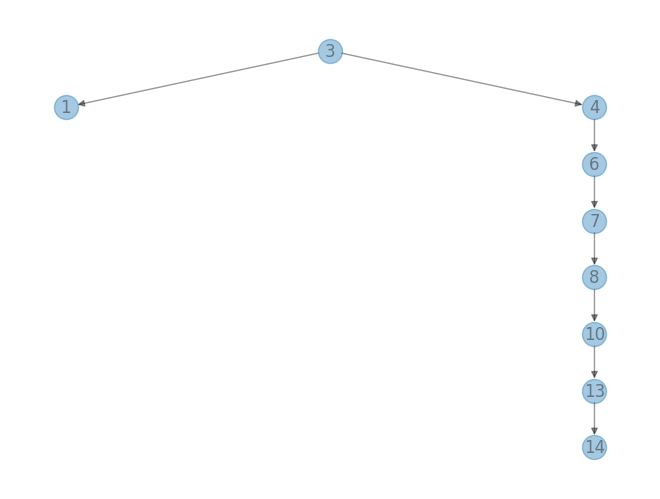

In [107]:
tree3.root = rotate_left(tree3.root)
draw_tree(tree3)

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)